In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import string
import codecs
import os
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import naive_bayes as bayes
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [2]:
#open file
file_path = "C:\\Users\\lenovo\\Documents\\tfstudy"
emailframe = pd.read_excel(os.path.join(file_path, "chinesespam.xlsx"), 0)

In [3]:
#inspect data
print("inspect top five rows:")
emailframe.head(5)

inspect top five rows:


,type,text
0,ham,1506讲的是孔子后人的故事。一个老领导回到家乡，跟儿子感情不和，跟贪财的孙子孔为本和睦。老...
1,ham,那他为什么不愿意起诉，既然这样了！起诉后也有充分的理由！MM莫不是还生活在电影中，个人认为这...
2,ham,我觉得，负债不要紧，最重要的是能负得起这个责任来，\n欠了那么多钱，至少对当初拿出爱心来的网...
3,ham,"公司现在有内部推荐机会,2-3人主要从事视频编解码器在pc/dsp/arm上的优化工作.(h..."
4,ham,鼓励一下！\n还是让姐姐们给你解答更好吧。\n 赫赫，很少有女生追男生的例子。不过还...


In [4]:
print("data shape:", emailframe.shape)
print("spams in rows:", emailframe.loc[emailframe['type'] == "spam"].shape[0])
print("ham in rows:", emailframe.loc[emailframe['type'] == "ham"].shape[0])

data shape: (150, 2)
spams in rows: 50
ham in rows: 100


In [5]:
#load stopwords
stopwords = codecs.open(os.path.join(file_path, 'stopwords.txt'), 'r', 'UTF8').read().split('\r\n')

In [6]:
#cut words and process text
processed_texts = []
for text in emailframe["text"]:
    words = []
    seg_list = jieba.cut(text)
    for seg in seg_list:
        if (seg.isalpha()) & (seg not in stopwords):
            words.append(seg)
    sentence = " ".join(words)
    processed_texts.append(sentence)
emailframe["text"] = processed_texts

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 1.213 seconds.
Prefix dict has been built succesfully.


In [7]:
#inspect processed text
emailframe.head(3)

,type,text
0,ham,讲 孔子 后人 故事 领导 回到 家乡 儿子 感情 贪财 孙子 孔为 和睦 领导 弟弟 魏宗...
1,ham,起诉 起诉 理由 MM 莫不是 生活 电影 中 结婚 感情 感情 何来 感情 传统 家庭 责...
2,ham,负债 不要紧 负得起 责任 欠 多钱 至少 当初 拿出 爱心 网友 交待 心 实在 能力 一...


In [8]:
#word cloud
def showWordCloud(text):
    wc = WordCloud(
    background_color="white",
    max_words=200,
    font_path="C:\\Windows\\Fonts\\STFANGSO.ttf",
    min_font_size=15,
    max_font_size=50, 
    width=400 
    )
    wordcloud = wc.generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

all words cloud:


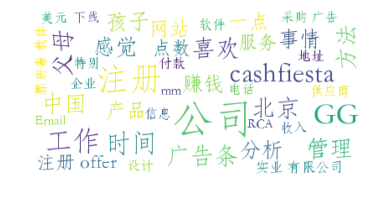

In [9]:
#all words cloud
print("all words cloud:")
showWordCloud(" ".join(emailframe["text"]))

spam words cloud:


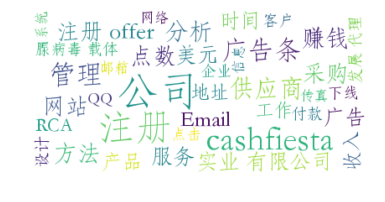

In [10]:
#spam words cloud
print("spam words cloud:")
spamtext = " ".join(emailframe[emailframe["type"] == "spam"]["text"])
showWordCloud(spamtext)

ham words cloud:


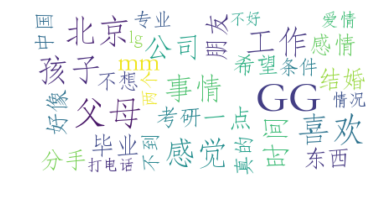

In [11]:
#ham words cloud
print("ham words cloud:")
spamtext = " ".join(emailframe[emailframe["type"] == "ham"]["text"])
showWordCloud(spamtext)

In [12]:
#transform text to sparse matrix
def transformTextToSparseMatrix(texts):
    vectorizer = CountVectorizer(binary=False)
    vectorizer.fit(texts)

    #inspect vocabulary
    vocabulary = vectorizer.vocabulary_
    print("There are ", len(vocabulary), " word features")
    
    vector = vectorizer.transform(texts)
    result = pd.DataFrame(vector.toarray())
    
    keys = []
    values = []
    for key,value in vectorizer.vocabulary_.items():
        keys.append(key)
        values.append(value)
    df = pd.DataFrame(data = {"key" : keys, "value" : values})
    colnames = df.sort_values("value")["key"].values
    result.columns = colnames
    return result

In [13]:
textmatrix = transformTextToSparseMatrix(emailframe["text"])
textmatrix.head(3)

There are  5982  word features


,aac,aav,abc,account,actionscript,activex,address,adenoviruses,age,agreement,...,黑镜头,黑龙江省,默认,默默,黯然,鼎力支持,鼎韵,鼓励,鼠标,齐全
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#pop freq words
features = pd.DataFrame(textmatrix.apply(sum, axis=0))
extractedfeatures = [features.index[i] for i in range(features.shape[0]) if features.iloc[i, 0] > 5]
textmatrix = textmatrix[extractedfeatures]
print("There are ", textmatrix.shape[1], " word features")

There are  544  word features


In [15]:
#traindate & testdata
train, test, trainlabel, testlabel = train_test_split(textmatrix, emailframe["type"], test_size = 0.2)

In [16]:
#train model
clf = bayes.BernoulliNB(alpha=1, binarize=True)
model = clf.fit(train, trainlabel)

In [17]:
#model score
model.score(test, testlabel)

0.8666666666666667